In [1]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

## Model Libraries
from sklearn.naive_bayes import BernoulliNB

In [2]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv")
df = df.drop_duplicates(subset='website')

In [3]:
df.head()

,Unnamed: 0,merchant_name,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist,contact_us_score,tnc_score,links_response,website,fraud_score,label
0,0,CV.ASIATRIPINDONESIA,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,100.0,100.0,{'https://asiatrip.id/reseller/': '<Response [...,http://asiatrip.id/,0.000000,APPROVED
1,1,Pt.BloomingLotusYoga,70.000000,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,{'http://www.blooming-lotus-yoga.com/bliss-mag...,https://www.blooming-lotus-yoga.com,0.000000,APPROVED
2,2,YayasanGreenSejahtera,11.111111,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,"{'': 'No Response/Timeout', 'https://greenseja...",https://greensejahterafoundation.com/,0.000000,APPROVED
3,3,PTMatairTerraSolusi,12.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'': 'No Response/Timeout', 'https://www.matai...",http://www.matair.co.id,0.666667,APPROVED
4,4,SimplyMii,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,{'https://www.simplymii.com/products/category/...,https://www.simplymii.com/,0.000000,APPROVED


In [4]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [5]:
X = df.iloc[:, 2:9]

In [6]:
## Binarize broken_link_score, with threshold 50.0
X["broken_link_score"] = (X["broken_link_score"] < 50.0)

In [7]:
for col in X:
    X[col] = X[col].astype(int)

In [8]:
X.head()

,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,1,1,1,1,0,1,1
1,0,1,1,1,1,1,1
2,1,1,1,1,1,1,1
3,1,0,0,0,1,0,0
4,1,1,1,1,0,0,0


In [9]:
X.shape

(292, 7)

In [10]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [11]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

## Cross Validation & Hyperparameter Tuning
Adopted from: https://weina.me/nested-cross-validation/

#### Data Splitting

In [12]:
## Divide data into train and "unseen" test set
## Unseen test set will be used for final testing after best hyperparameter sets chose
X_train, X_test_unseen, y_train, y_test_unseen = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
y_train.value_counts()

0    159
1     60
Name: label, dtype: int64

In [14]:
y_test_unseen.value_counts()

0    56
1    17
Name: label, dtype: int64

#### Find The Best Hyperparameter Candidates

In [23]:
## Define a parameters grid
p_grid = {"alpha": [0.5,1.0], "fit_prior": [True, False]}

In [24]:
## Split train data to 5 (outer) folds
skfold = StratifiedKFold(n_splits=5)

In [25]:
i = 1
folds = []
for train_index_outer, test_index_outer in skfold.split(X_train, y_train):
    fold_data = {}
    
    print("Outer Fold %s" % i)
    data_X_train = X_train.iloc[train_index_outer]
    data_y_train = y_train.iloc[train_index_outer]
    data_X_test = X_train.iloc[test_index_outer]
    
    ## Define model
    model = BernoulliNB()
    
    ## Do cross validation in inner fold, get the best params
    clf = GridSearchCV(model, p_grid, scoring='roc_auc', cv=skfold)
    clf.fit(data_X_train, data_y_train)
    print("Best Params: %s" % clf.best_params_)
    print("Best Avg. Score: %s" % clf.best_score_)
    fold_data['outer_fold'] = i
    fold_data['best_param'] = clf.best_params_
    fold_data['best_score'] = clf.best_score_
    folds.append(fold_data)
    
    i+=1

Outer Fold 1
Best Params: {'alpha': 0.5, 'fit_prior': True}
Best Avg. Score: 0.9189743589743589
Outer Fold 2
Best Params: {'alpha': 1.0, 'fit_prior': True}
Best Avg. Score: 0.9347316239316239
Outer Fold 3
Best Params: {'alpha': 1.0, 'fit_prior': True}
Best Avg. Score: 0.9413709401709403
Outer Fold 4
Best Params: {'alpha': 1.0, 'fit_prior': True}
Best Avg. Score: 0.9373709401709401
Outer Fold 5
Best Params: {'alpha': 0.5, 'fit_prior': True}
Best Avg. Score: 0.9217658119658119


In [26]:
folds

[{'outer_fold': 1,
  'best_param': {'alpha': 0.5, 'fit_prior': True},
  'best_score': 0.9189743589743589},
 {'outer_fold': 2,
  'best_param': {'alpha': 1.0, 'fit_prior': True},
  'best_score': 0.9347316239316239},
 {'outer_fold': 3,
  'best_param': {'alpha': 1.0, 'fit_prior': True},
  'best_score': 0.9413709401709403},
 {'outer_fold': 4,
  'best_param': {'alpha': 1.0, 'fit_prior': True},
  'best_score': 0.9373709401709401},
 {'outer_fold': 5,
  'best_param': {'alpha': 0.5, 'fit_prior': True},
  'best_score': 0.9217658119658119}]

In [27]:
df_outer_fold_result = pd.DataFrame({"outer_fold":[], "alpha":[], "fit_prior":[], "best_score":[]})
for fold in folds:
    res = pd.concat([pd.DataFrame(fold['best_param'], index=[0]),\
                    pd.DataFrame(fold, index=[0]).drop('best_param', axis=1)], axis=1)
    df_outer_fold_result = pd.concat([df_outer_fold_result, res])

In [28]:
df_outer_fold_result

,outer_fold,alpha,fit_prior,best_score
0,1.0,0.5,1.0,0.918974
0,2.0,1.0,1.0,0.934732
0,3.0,1.0,1.0,0.941371
0,4.0,1.0,1.0,0.937371
0,5.0,0.5,1.0,0.921766


#### Test All Candidates To Unseen Data

In [29]:
pred_class = []
pred_proba = []
pred_auc = []
for fold in folds:
    model = BernoulliNB(alpha=fold['best_param']['alpha'],\
                        fit_prior=fold['best_param']['fit_prior'])
    
    ## Predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_unseen)
    y_pred_proba = model.predict_proba(X_test_unseen)
    
    ## Print metrics
    print("==============================")
    print("Fold %s" % fold['outer_fold'])
    print("Parameter: %s" % fold['best_param'])
    fpr, tpr, thresholds = roc_curve(y_test_unseen, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_test_unseen, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test_unseen, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print("AUC: %.3f" % auc_score)
    print("Accuracy: %.3f " % accuracy)
    print("Precision: %.3f " % precision)
    print("Recall: %.3f " % recall)
    print("F1 Score: %.3f " % f1_score)
    print("True Positive: %s" % tp)
    print("False Positive: %s" % fp)
    print("True Negative: %s" % tn)
    print("False Negative: %s" % fn)
    print("==============================")
    
    pred_class.append(y_pred)
    pred_proba.append(y_pred_proba)
    pred_auc.append(auc_score)

Fold 1
Parameter: {'alpha': 0.5, 'fit_prior': True}
AUC: 0.955
Accuracy: 0.877 
Precision: 0.682 
Recall: 0.882 
F1 Score: 0.769 
True Positive: 15
False Positive: 7
True Negative: 49
False Negative: 2
Fold 2
Parameter: {'alpha': 1.0, 'fit_prior': True}
AUC: 0.955
Accuracy: 0.877 
Precision: 0.682 
Recall: 0.882 
F1 Score: 0.769 
True Positive: 15
False Positive: 7
True Negative: 49
False Negative: 2
Fold 3
Parameter: {'alpha': 1.0, 'fit_prior': True}
AUC: 0.955
Accuracy: 0.877 
Precision: 0.682 
Recall: 0.882 
F1 Score: 0.769 
True Positive: 15
False Positive: 7
True Negative: 49
False Negative: 2
Fold 4
Parameter: {'alpha': 1.0, 'fit_prior': True}
AUC: 0.955
Accuracy: 0.877 
Precision: 0.682 
Recall: 0.882 
F1 Score: 0.769 
True Positive: 15
False Positive: 7
True Negative: 49
False Negative: 2
Fold 5
Parameter: {'alpha': 0.5, 'fit_prior': True}
AUC: 0.955
Accuracy: 0.877 
Precision: 0.682 
Recall: 0.882 
F1 Score: 0.769 
True Positive: 15
False Positive: 7
True Negative: 49
False Ne

In [30]:
## Best hyperparameter test to unseen data
fold_best = folds[np.argmax(pred_auc)]

In [32]:
## Predict with the best params
model = BernoulliNB(alpha=fold_best['best_param']['alpha'],\
                    fit_prior=fold_best['best_param']['fit_prior'])        
model.fit(X_train, y_train)
y_pred = model.predict(X_test_unseen)
y_pred_proba = model.predict_proba(X_test_unseen)

In [33]:
fpr, tpr, thresholds = roc_curve(y_test_unseen, y_pred_proba[:,1])
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test_unseen, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test_unseen, y_pred).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("AUC: %.3f" % auc_score)
print("Accuracy: %.3f " % accuracy)
print("Precision: %.3f " % precision)
print("Recall: %.3f " % recall)
print("F1 Score: %.3f " % f1_score)
print("True Positive: %s" % tp)
print("False Positive: %s" % fp)
print("True Negative: %s" % tn)
print("False Negative: %s" % fn)

AUC: 0.955
Accuracy: 0.877 
Precision: 0.682 
Recall: 0.882 
F1 Score: 0.769 
True Positive: 15
False Positive: 7
True Negative: 49
False Negative: 2


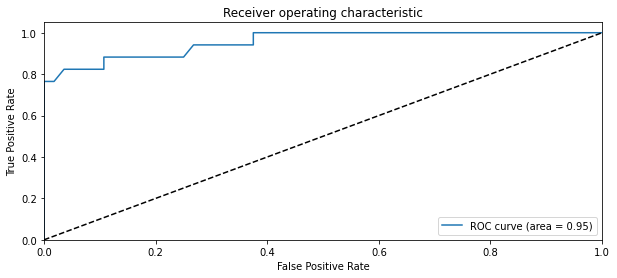

In [34]:
## ROC AUC Graph
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [36]:
## Calculate feature importance by seeing empirical log probability of features given a class, P(x_i|y).
feat_log_prob_0 = model.feature_log_prob_[0]
feat_log_prob_1 = model.feature_log_prob_[1]
feat_name = X_train.columns.values

In [38]:
## Class prior
print(model.class_log_prior_)

[-0.32016753 -1.29472717]


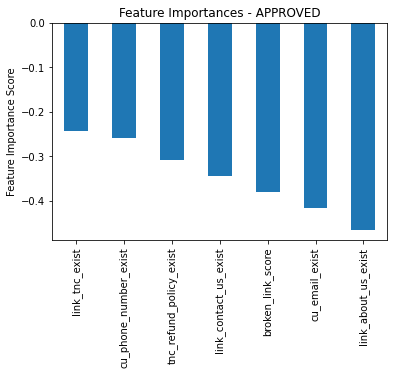

In [39]:
feat_imp = pd.Series(index=feat_name, data=feat_log_prob_0).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances - APPROVED')
plt.ylabel('Feature Importance Score')
plt.show()

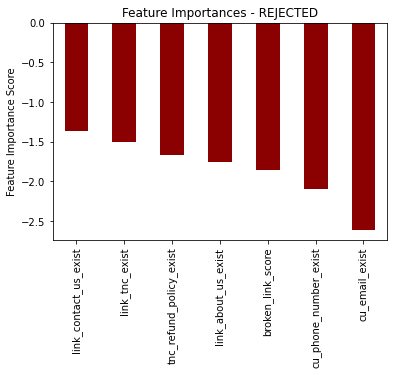

In [40]:
feat_imp = pd.Series(index=feat_name, data=feat_log_prob_1).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances - REJECTED', color='darkred')
plt.ylabel('Feature Importance Score')
plt.show()

## Dump To Pickle

In [41]:
# clf = model_choice
# clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/model.pickle', 'wb'))